# GraphDB(neo4j)

In [1]:
from neo4j import GraphDatabase
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import os

## グラフデータベースの接続

In [196]:
# neo4j serverに接続するdriverの設定
driver = GraphDatabase.driver('neo4j://graph-db:7687')

In [197]:
# relationがあるデータを取得する
def fetch_transaction(tx, contract_address):
    query = "MATCH p=()-[r:TRANSFER {contractAddress: $address}]->() RETURN p"
    
    transactions = tx.run(query, address=contract_address)
    return list(transactions)

In [198]:
contract_address = "0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D"
transactions = list()
relations = list()

# neo4jに接続してトランザクションを実行
with driver.session() as session:
    transactions = session.execute_read(fetch_transaction, contract_address)

# トランザクションの結果をリストに保存
for transaction in transactions:
    path = transaction["p"]
    start_node = path.start_node
    end_node = path.end_node
    gasPrice = transaction["p"].relationships[0]["gasPrice"]
    gasUsed = transaction["p"].relationships[0]["gasUsed"]

    relations.append({
        "from": start_node["address"], 
        "to": end_node["address"],
        "gasPrice": gasPrice,
        "gasUsed": gasUsed
    })

# 結果をpandasで保存
df_relation = pd.DataFrame(relations)
display(df_relation)

,from,to,gasPrice,gasUsed
0,0x90e3d7C40F72F1fB3189AFC86e92c67dAfabB323,0x0c7415dDBAFabc13206631DBf1B83f6eBD4Ee144,51.193516,0.000168
1,0x0c7415dDBAFabc13206631DBf1B83f6eBD4Ee144,0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,35.980158,0.000139
2,0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,24.822893,0.000086
3,0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0xA38dd89354f31235917C43632692A1f10FAfc8b2,20.640621,0.000098
4,0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,20.725437,0.000086
...,...,...,...,...
861,0xA8D0FB9Cb5c19ecA739B8107319E8bA52aaD235d,0xE11FA60b695e8Af82BaA9277f2a1BCf55c58D13d,0.003081,0.000085
862,0xE11FA60b695e8Af82BaA9277f2a1BCf55c58D13d,0xA8D0FB9Cb5c19ecA739B8107319E8bA52aaD235d,44.009468,0.000152
863,0xA8D0FB9Cb5c19ecA739B8107319E8bA52aaD235d,0xb5d87c32261b64B821B10D217B891eaaA5B21F0e,41.858360,0.000169
864,0xb5d87c32261b64B821B10D217B891eaaA5B21F0e,0xA8D0FB9Cb5c19ecA739B8107319E8bA52aaD235d,251.647899,0.000142


In [199]:
directory = f"data/{contract_address}"

# ディレクトリが存在しない場合は作成
if not os.path.exists(directory):
    os.makedirs(directory)

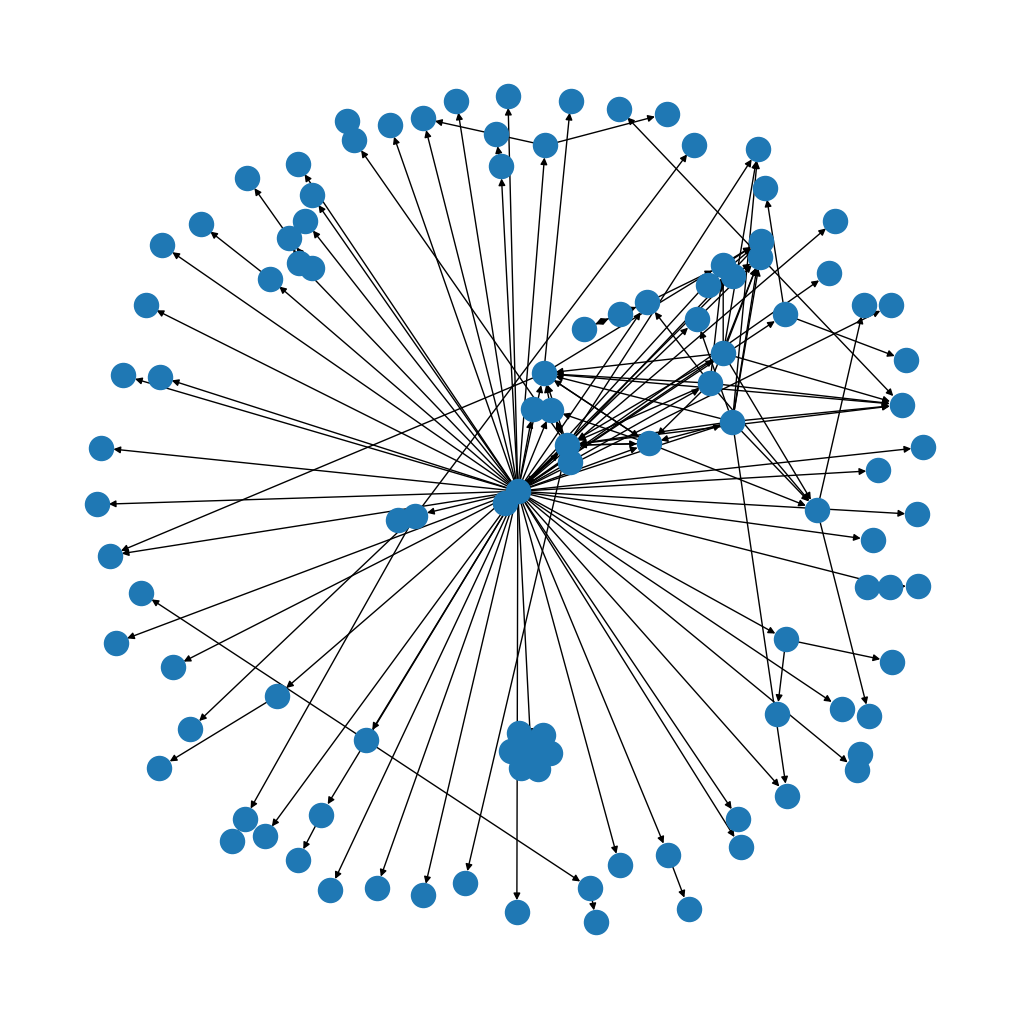

In [200]:
G = nx.DiGraph()

for index, transaction in df_relation.iterrows():
    G.add_edge(transaction["from"], transaction["to"])

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False)
plt.savefig(os.path.join(directory, 'graph.png'), dpi=300)
plt.show()

In [201]:
df_centrality = pd.DataFrame(
    index=list(G.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 次数中心性
degree = nx.in_degree_centrality(G)
df_centrality["degree"] = pd.Series(degree)
# 媒介中心性
betweenness = nx.betweenness_centrality(G)
df_centrality["betweenness"] = pd.Series(betweenness)
# # PageRank
pagerank = nx.pagerank(G, max_iter=1000)
df_centrality["pagerank"] = pd.Series(pagerank)

display(df_centrality)

,degree,betweenness,pagerank
0x90e3d7C40F72F1fB3189AFC86e92c67dAfabB323,0.009434,0.001078,0.012048
0x0c7415dDBAFabc13206631DBf1B83f6eBD4Ee144,0.009434,0.000539,0.014763
0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,0.028302,0.002965,0.017709
0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0.018868,0.077553,0.009843
0xA38dd89354f31235917C43632692A1f10FAfc8b2,0.066038,0.069458,0.017553
...,...,...,...
0xd4397486087F96169DF8e595fF5cd105fFff714f,0.009434,0.000000,0.007902
0xE11FA60b695e8Af82BaA9277f2a1BCf55c58D13d,0.009434,0.000000,0.018669
0x5a8E4A224D4548a1100047E7B9C2Be39477407a4,0.009434,0.000988,0.004664
0xAc76BbE2230a7cBcC0712Cc0992F1767D6C75Dff,0.009434,0.000000,0.008487


## 可視化、数値の算出

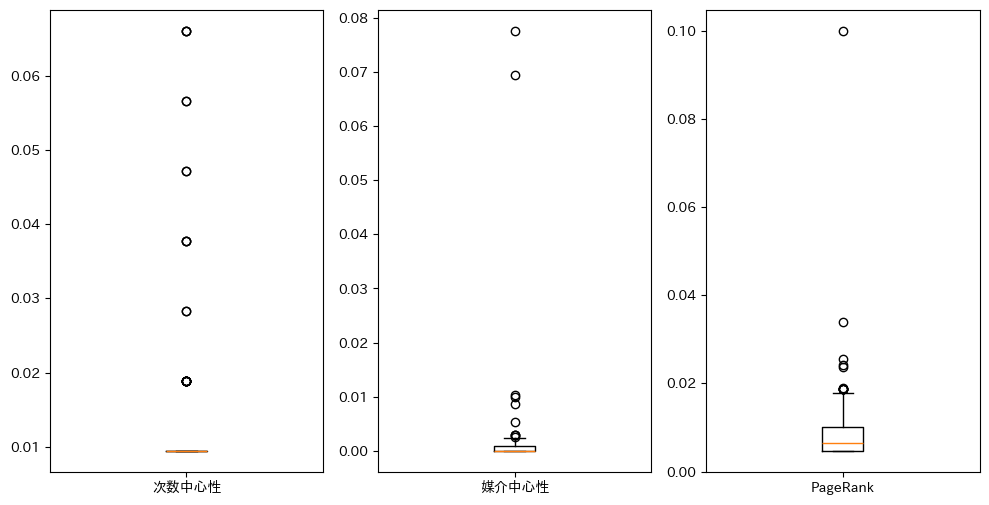

In [202]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.boxplot(df_centrality["degree"])
plt.xticks([1], ["次数中心性"])

plt.subplot(1, 3, 2)
plt.boxplot(df_centrality["betweenness"])
plt.xticks([1], ["媒介中心性"])

plt.subplot(1, 3, 3)
plt.boxplot(df_centrality["pagerank"])
plt.xticks([1], ["PageRank"])

plt.savefig(os.path.join(directory, 'box.png'), dpi=300)

plt.show()

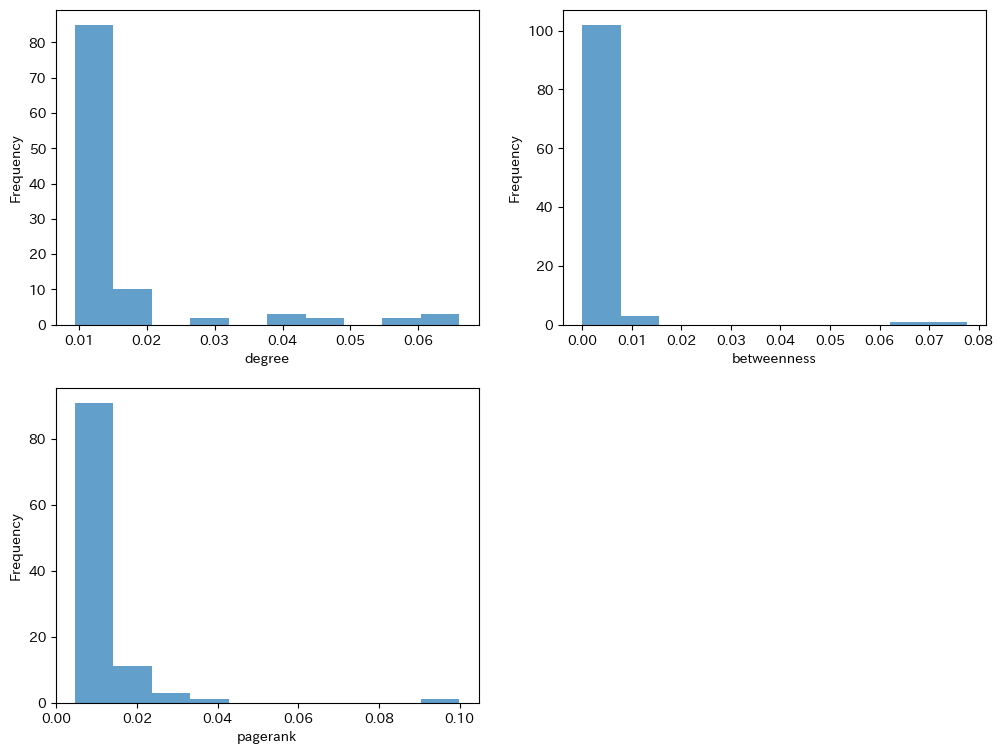

In [203]:
# ヒストグラム
plt.figure(figsize=(12, 9))
for i, column in enumerate(df_centrality.columns):
    plt.subplot(2, 2, i + 1)  # 1行3列のi+1番目
    plt.hist(df_centrality[column], alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.savefig(os.path.join(directory, 'hist.png'), dpi=300)
plt.show()

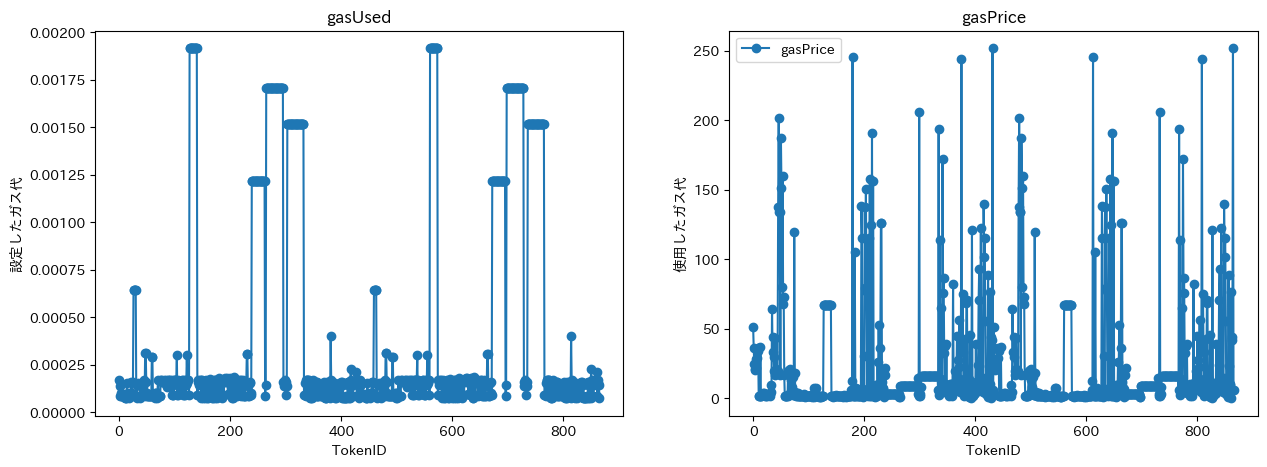

In [204]:
# データの準備
x = list(range(len(df_relation["gasUsed"])))  # X軸の値

plt.figure(figsize=(15, 5))

# グラフの描画
plt.subplot(1, 2, 1)
plt.plot(x, df_relation["gasUsed"], label='gasUsed', marker='o')  # データセット1をプロット
# グラフのタイトルとラベルを設定
plt.title('gasUsed')
plt.xlabel('TokenID')
plt.ylabel('設定したガス代')

plt.subplot(1, 2, 2)
plt.plot(x, df_relation["gasPrice"], label='gasPrice', marker='o')  # データセット2をプロット
# グラフのタイトルとラベルを設定
plt.title('gasPrice')
plt.xlabel('TokenID')
plt.ylabel('使用したガス代')

# 凡例を表示
plt.legend()

plt.savefig(os.path.join(directory, 'gas.png'), dpi=300)

# グラフを表示
plt.show()

## ガス代の予測(バギング)

In [205]:
# データの用意
df = pd.merge(df_relation, df_centrality, left_on="from", right_index=True)
df = pd.merge(df, df_centrality, left_on="to", right_index=True, suffixes=("_from", "_to"))

X = df.drop(["gasPrice", "gasUsed", "from", "to"], axis=1) # 説明変数
y = df[["gasUsed"]]  # 目的変数

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

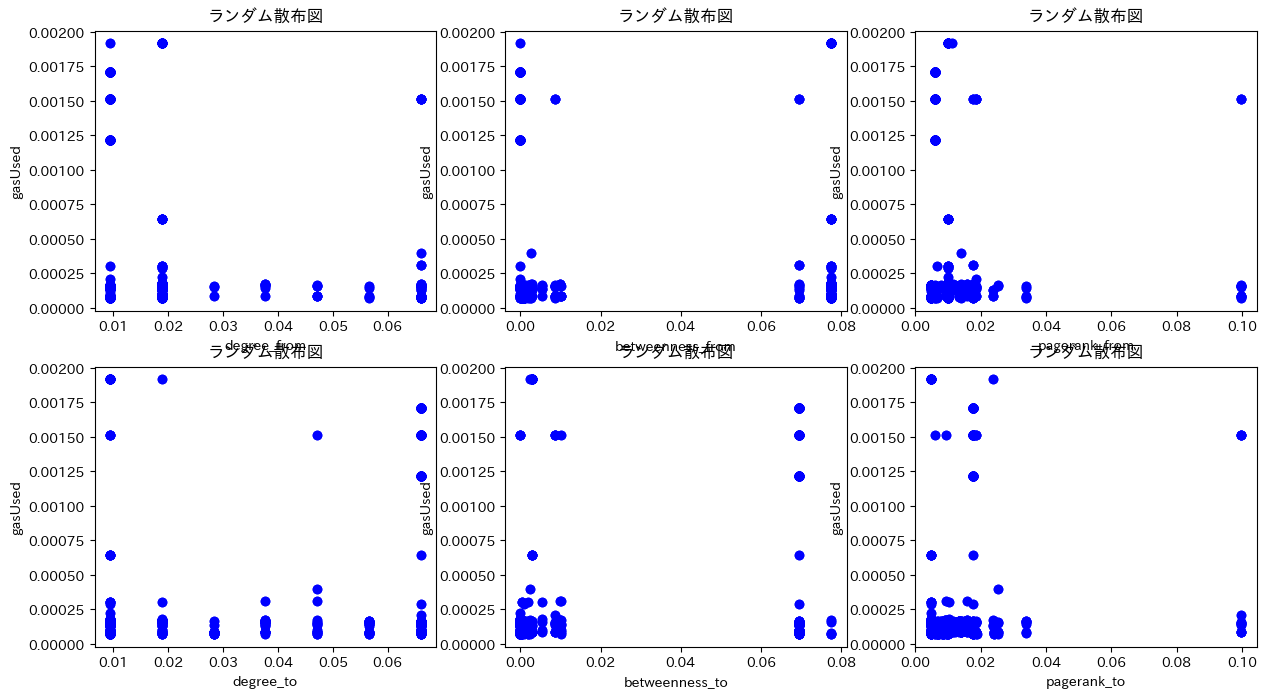

In [206]:
# 散布図を作成
plt.figure(figsize=(15, 8))

for index, column in enumerate(["degree_from", "betweenness_from", "pagerank_from", "degree_to", "betweenness_to", "pagerank_to"]):
    plt.subplot(2, 3, index+1)

    x = X[column]
    y = df[["gasUsed"]]

    # 散布図を作成
    plt.scatter(x, y, color='blue', marker='o')

    # タイトルとラベルを設定
    plt.title('ランダム散布図')
    plt.xlabel(column)
    plt.ylabel('gasUsed')

# グラフを表示
plt.show()

R2: 0.7178769111633301
MSE: 9.881224391483901e-08
MAE: 0.00016884274239298204
RMSE: 0.00031434414884778597


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

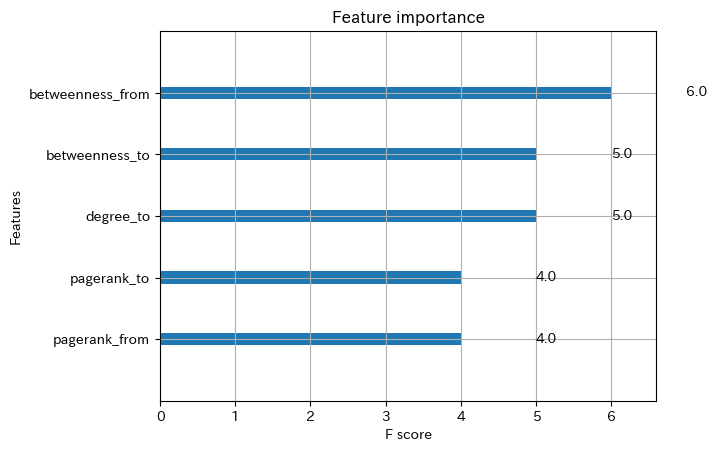

In [207]:
# XGBoostモデルの作成
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# モデルの訓練
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# モデルの評価
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# 重要度の可視化
xgb.plot_importance(model)


## データのインポート

In [208]:
# path = "data/contracts.csv"

# try:
#     # CSVファイルを読み込む
#     df = pd.read_csv(path)
    
#     # ヘッダーを出力する
#     print(df.columns)
# except FileNotFoundError:
#     print("エラー: 指定されたCSVファイルが見つかりません。ファイルのパスを確認してください。")
# except Exception as e:
#     print(f"予期しないエラーが発生しました: {e}")

In [209]:
# def create_node(tx, addresses, type):
#     for index, address in enumerate(addresses):
#         # データを取得する
#         fetch_query = "MATCH p=(u:User {address: $address}) RETURN p"
#         node = tx.run(fetch_query, address=address)
#         node = list(node)
        
#         # ノードが追加されていなければノードを追加する
#         if len(node) < 1:
#             create_query = "CREATE (u:User {address: $address, type: $type})"
#             node = tx.run(create_query, address=address, type=type)
#             if index % 100 == 0:
#                 print(index, end=", ")
#             with open("data/node.log", mode="a") as f:
#                 f.write(f"{index} node created \n")

#     print("")
#     print(f"saved {type} nodes")
#     return node
        

In [210]:
# def create_relation(tx, df, token_id, contract_address):
#     for index, row in df.iterrows():
#         query = "MATCH (from:User {address: $fromAddress}), (to:User {address: $toAddress}) CREATE (from)-[:TRANSFER {tokenId: $tokenId, contractAddress: $contractAddress}]->(to)"
#         node = tx.run(query, fromAddress=row["from_address"], toAddress=row["to_address"], tokenId=token_id, contractAddress=contract_address)
#         if index % 100 == 0:
#                 print(index, end=", ")
#         with open("data/relation.log", mode="a") as f:
#                 f.write(f"{index} relation created {row["from_address"]} -> {row["to_address"]} \n")
#     print("saved relations")


In [211]:
# contract_address = "csv"
# token_id = 1

# with driver.session() as session:
#     # fromノードの追加
#     node = session.execute_write(create_node, df["from_address"], "from")  

#     # toノードの追加
#     node = session.execute_write(create_node, df["from_address"], "to")

#     # releationの追加
#     node = session.execute_write(create_relation, df, token_id, contract_address)
